In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import os

from functions.utils import state_dict_to_vector

from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model
from model.alt_loss_A import Loss
from model.collectdata_poca_KDE import collect_data_poca
device = 'cuda:1'

In [2]:
#dict with run_title : (num_events (in thousands), list of (num_epochs, dir_name))
all_runs = {
    'Adam':(160,
                      [(200, 'TEST_AllCNN_control_Adam')]),
    'adaptive_careful2_Adam':(160,
                      [(200, 'TEST_AllCNN_adaptive_fixedcarefulAdam')])
    
    }

#to quickly call runs via number
run_names = {}
for i,key in enumerate(list(all_runs)):
    print(i, ':', key)
    run_names[i] = key

0 : Adam
1 : adaptive_careful2_Adam


In [3]:
#Select runs to plot
runs = [0,1]#[i for i in range(len(all_runs))]

run_labels = [run_names[i] for i in runs]

#now to generate list of paths to the stored model dicts
dict_paths = []
num_epochs = []
for run_label in run_labels:
    these_paths = []
    this_num_epochs = 0
    dir_tuples = all_runs[run_label][1]
    for dir_tuple in dir_tuples:
        
        this_num_epochs += dir_tuple[0]
        dir_name = dir_tuple[1]
        for j in range(dir_tuple[0]):
            #print('ML/' + dir_names[i] + '/' + dir_names[i] + '_%i.pyt'%(j))
            these_paths.append('baileyds/AllCNN/' + dir_name + '/' + dir_name + '_%i.pyt'%(j))
    dict_paths.append(these_paths)
    num_epochs.append(this_num_epochs)   
    
print(dict_paths)

[['baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_0.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_1.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_2.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_3.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_4.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_5.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_6.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_7.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_8.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_9.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_10.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_11.pyt', 'baileyds/AllCNN/TEST_AllCNN_control_Adam/TEST_AllCNN_control_Adam_12.pyt', 'baileyds/AllCNN/TES

In [4]:
for paths in dict_paths:
    for filepath in paths:
        if os.path.exists(filepath) == False:
            print(filepath, os.path.exists(filepath))

In [5]:
val_data = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=32,
  #                          device=device,
                            masking=True,
                            shuffle=False,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 4.607 s
Constructing 20000 event dataset took 0.08078 s


In [6]:
from model.models_mjp_30Jan21 import BM_ACN_1_6L as Model

model = Model()
model.to(device)
loss_fn = Loss(epsilon=1e-5,coefficient=2.5)

In [7]:
def train_loss(dataloader, model, loss_fn):
    model.train()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    return test_loss/len(dataloader)

def eval_loss(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    return test_loss/len(dataloader)

In [8]:
eval_losses = []

scan_sizes = {18:20, 80:5, 160:5, 320:1}

for i,paths in enumerate(dict_paths):
    print('On run:', run_labels[i])
    these_train_losses = []
    these_eval_losses = []
    scan_size = scan_sizes[all_runs[run_labels[i]][0]]
    print(f'{all_runs[run_labels[i]][0]}k events -> scan size = {scan_size}')
    for ep in np.arange(0, num_epochs[i], scan_size):
        print("Epoch:", ep, '/', num_epochs[i])
        state_dict = torch.load(paths[ep], map_location=device)
        model.load_state_dict(state_dict)
#         start_time = time.time()
#         these_train_losses.append(train_loss(train_data, model, loss_fn))
#         print("Train loss time:", time.time()-start_time)
        start_time = time.time()
        these_eval_losses.append(eval_loss(val_data, model, loss_fn))
        print("Eval loss time:", time.time()-start_time)
        print('#############################################')
    #eval_losses.append(these_eval_losses)
    #add the last values if not added
    if ep != (len(paths)-1):
        ep = (len(paths)-1)
        print("Epoch:", ep, '/', num_epochs[i])
        state_dict = torch.load(paths[ep], map_location=device)
        model.load_state_dict(state_dict)
#         start_time = time.time()
#         these_train_losses.append(train_loss(train_data, model, loss_fn))
#         print("Train loss time:", time.time()-start_time)
        start_time = time.time()
        these_eval_losses.append(eval_loss(val_data, model, loss_fn))
        print("Eval loss time:", time.time()-start_time)
        print('#############################################')
    eval_losses.append(these_eval_losses)
    
with open('AllCNN_runs_savedloss.txt', 'w') as f:
    for i in range(len(dict_paths)):
        print(i)
        this_loss = eval_losses[i]
        for j in range(len(this_loss)):
            f.write(str(this_loss[j]))
            if j+1 in range(len(this_loss)):
                f.write(',')
        if i+1 in range(len(dict_paths)):
            f.write('\n')

On run: Adam
160k events -> scan size = 5
Epoch: 0 / 200
Eval loss time: 1.6556973457336426
#############################################
Epoch: 5 / 200
Eval loss time: 1.7111763954162598
#############################################
Epoch: 10 / 200
Eval loss time: 1.7346255779266357
#############################################
Epoch: 15 / 200
Eval loss time: 1.5424997806549072
#############################################
Epoch: 20 / 200
Eval loss time: 1.569077730178833
#############################################
Epoch: 25 / 200
Eval loss time: 1.5513594150543213
#############################################
Epoch: 30 / 200
Eval loss time: 1.5721604824066162
#############################################
Epoch: 35 / 200
Eval loss time: 1.533323049545288
#############################################
Epoch: 40 / 200
Eval loss time: 1.563905954360962
#############################################
Epoch: 45 / 200
Eval loss time: 1.5527966022491455
#######################################

In [9]:
eval_losses = []
with open('AllCNN_runs_savedloss.txt', 'r') as f:
    idx = 0
    for line in f:
        if idx in runs:
            line.split(',')
            eval_losses.append([float(val) for val in line.split(',')])
        idx += 1

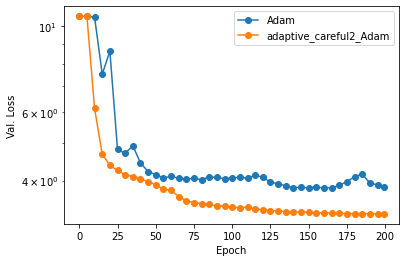

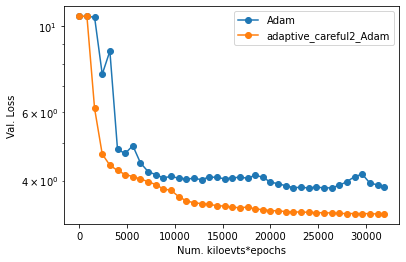

In [10]:
plt.figure()
for i in range(len(dict_paths)):
    scan_size = scan_sizes[all_runs[run_labels[i]][0]]
    if np.arange(0, num_epochs[i], scan_size)[-1] != (num_epochs[i]-1):
        plt.plot(np.append(np.arange(0, num_epochs[i], scan_size), [num_epochs[i]-1]), eval_losses[i], 'o-', label=run_labels[i])
    else:
        plt.plot(np.arange(0, num_epochs[i], scan_size), eval_losses[i], 'o-', label=run_labels[i])
plt.xlabel("Epoch")
plt.ylabel("Val. Loss")
plt.yscale('log')
plt.legend()

#now approx. normalizing x axis for comp time
plt.figure()
for i in range(len(dict_paths)):
    num_evts = all_runs[run_labels[i]][0]
    scan_size = scan_sizes[all_runs[run_labels[i]][0]]
    if np.arange(0, num_epochs[i], scan_size)[-1] != num_epochs[i]-1:
        plt.plot(num_evts*np.append(np.arange(0, num_epochs[i], scan_size), [num_epochs[i]-1]), eval_losses[i], 'o-', label=run_labels[i])
    else:
        plt.plot(num_evts*np.arange(0, num_epochs[i], scan_size), eval_losses[i], 'o-', label=run_labels[i])
plt.xlabel("Num. kiloevts*epochs")
plt.ylabel("Val. Loss")
plt.yscale('log')
plt.legend()